Dataset downloaded successfully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).

Initial shape: (170653, 19)ully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).


After dropping missing values: (170653, 19)


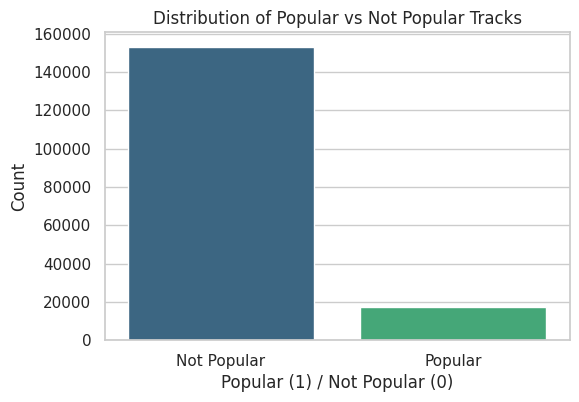

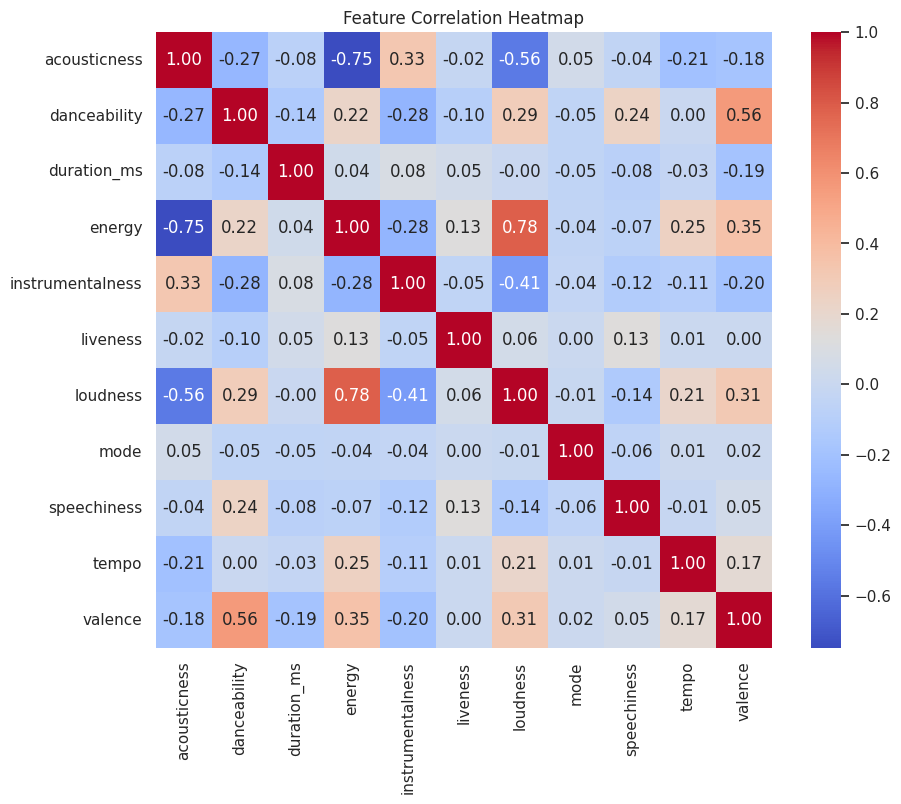

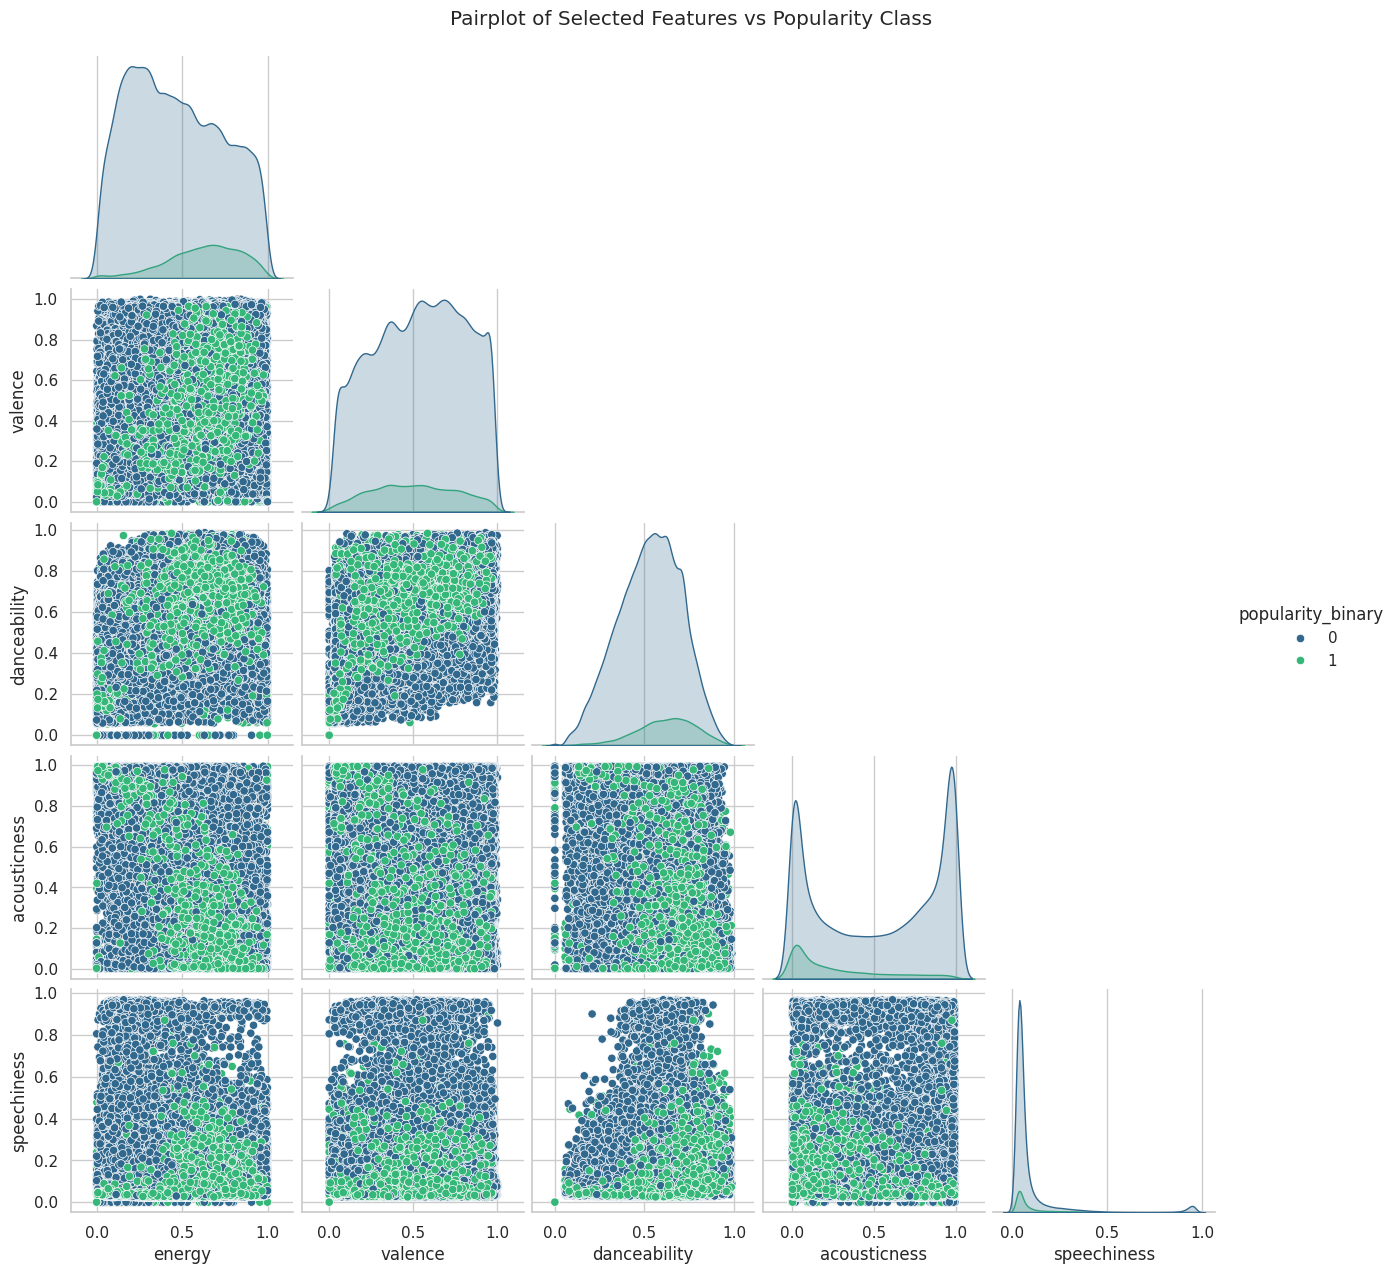

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# =============================================================================
# Lab 6: Support Vector Machine (SVM) Classification
# =============================================================================

# Aim:
# To implement and evaluate a Support Vector Machine (SVM) classifier
# on the Spotify dataset for predicting whether a track is popular or not.

# Objective:
# 1. Load and understand the Spotify dataset’s attributes.
# 2. Conduct Exploratory Data Analysis (EDA) to study feature relationships.
# 3. Preprocess and transform the target variable for binary classification.
# 4. Train and evaluate an SVM classifier with hyperparameter tuning.
# 5. Report classification metrics and results.

# =============================================================================
# Libraries
# =============================================================================

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
)

import kagglehub
import warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid')
%matplotlib inline

# =============================================================================
# Data Description & Loading
# =============================================================================

def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()
print(f"Initial shape: {df.shape}")
df.head()

# =============================================================================
# EDA
# =============================================================================

features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'

df = df.dropna(subset=features + [target])
print(f"After dropping missing values: {df.shape}")

df['popularity_binary'] = (df['popularity'] >= 60).astype(int)

# Plot class balance
plt.figure(figsize=(6,4))
sns.countplot(x='popularity_binary', data=df, palette='viridis')
plt.title("Distribution of Popular vs Not Popular Tracks")
plt.xlabel("Popular (1) / Not Popular (0)")
plt.ylabel("Count")
plt.xticks([0,1], ["Not Popular", "Popular"])
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot on top features
top_feats = ['energy', 'valence', 'danceability', 'acousticness', 'speechiness']
sns.pairplot(df[top_feats + ['popularity_binary']], hue='popularity_binary', corner=True, palette='viridis')
plt.suptitle("Pairplot of Selected Features vs Popularity Class", y=1.02)
plt.show()

# =============================================================================
# Model Train / Validation / Test
# =============================================================================

X = df[features].values
y = df['popularity_binary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    svm_clf,
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# =============================================================================
# Results
# =============================================================================

# Accuracy
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test, target_names=["Not Popular", "Popular"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Popular", "Popular"])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix on Test Set")
plt.show()

# Prediction Probability Histogram (optional if using RBF with probability=True)
if 'rbf' in grid_search.best_params_['kernel']:
    svm_prob = SVC(**grid_search.best_params_, probability=True)
    svm_prob.fit(X_train_scaled, y_train)
    y_prob = svm_prob.predict_proba(X_test_scaled)[:,1]

    plt.figure(figsize=(6,4))
    sns.histplot(y_prob, bins=30, kde=True, color='navy')
    plt.title("Distribution of Predicted Probabilities (Class = Popular)")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.show()

# =============================================================================
# Concluding Remarks
# =============================================================================

print("Concluding Remarks:")
print("- Successfully trained an SVM classifier to predict track popularity.")
print("- Applied feature scaling and tuned hyperparameters via GridSearchCV.")
print(f"- Final test accuracy: {test_acc:.2%}")
print("- Visualized prediction results with confusion matrix and EDA insights.")
print("- Future improvements may include balancing class labels or using ensemble methods.")
